## Geonames

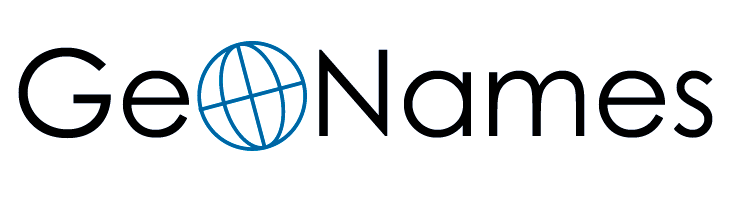

* [live example](http://www.geonames.org/search.html?q=cork+ireland&country=)
* The geonames geographical database is available for download free of charge under a creative commons attribution license.
* It contains over 10 million geographical names and consists of over 9 million unique features, whereof 2.8 million populated places and 5.5 million alternate names.

In [91]:
import os

from dotenv import load_dotenv
load_dotenv()

GEONAMES_KEY = os.environ['GEONAMES_KEY']

In [92]:
from io import BytesIO
from zipfile import ZipFile

import requests
import pandas as pd

COLUMNS = '''
geonameid
name unicode
name ascii
alternatenames
latitude
longitude
feature class
feature code
country code
alternate country code
fipscode
admin. division 2
admin. division 3
admin. division 4
population
elevation
digital elevation model
timezone
modification date
'''
COLUMNS = [x.strip() for x in COLUMNS.split('\n') if x.strip()]

def get_cities():
    r = requests.get('http://download.geonames.org/export/dump/cities1000.zip')
    zip_data = BytesIO(r.content)

    with ZipFile(zip_data, 'r') as archive:
        with archive.open('cities1000.txt') as fhandle:
            for city in fhandle:
                city = city.decode('utf-8')
                parts = city.split('\t')
                yield dict(zip(COLUMNS, parts))

In [93]:
cities_list = list(get_cities())

cities_df = pd.DataFrame(cities_list)
cities_df = cities_df.reindex(COLUMNS, axis=1)
cities_df.head()

,geonameid,name unicode,name ascii,alternatenames,latitude,longitude,feature class,feature code,country code,alternate country code,fipscode,admin. division 2,admin. division 3,admin. division 4,population,elevation,digital elevation model,timezone,modification date
0,3039154,El Tarter,El Tarter,"Ehl Tarter,Эл Тартер",42.57952,1.65362,P,PPL,AD,,02,,,,1052,,1721,Europe/Andorra,2012-11-03\n
1,3039163,Sant Julià de Lòria,Sant Julia de Loria,"San Julia,San Julià,Sant Julia de Loria,Sant J...",42.46372,1.49129,P,PPLA,AD,,06,,,,8022,,921,Europe/Andorra,2013-11-23\n
2,3039604,Pas de la Casa,Pas de la Casa,"Pas de la Kasa,Пас де ла Каса",42.54277,1.73361,P,PPL,AD,,03,,,,2363,2050,2106,Europe/Andorra,2008-06-09\n
3,3039678,Ordino,Ordino,"Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...",42.55623,1.53319,P,PPLA,AD,,05,,,,3066,,1296,Europe/Andorra,2009-12-11\n
4,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,,08,,,,15853,,1033,Europe/Andorra,2008-10-15\n


In [94]:
len(cities_df)

128764

In [95]:
df = cities_df
df.loc[df['name ascii'] == 'Cork']

,geonameid,name unicode,name ascii,alternatenames,latitude,longitude,feature class,feature code,country code,alternate country code,fipscode,admin. division 2,admin. division 3,admin. division 4,population,elevation,digital elevation model,timezone,modification date
53781,2965140,Cork,Cork,"Corc,Corcagia,Corcaigh,Cork,Cork - Corcaigh,Co...",51.89797,-8.47061,P,PPLA2,IE,,M,04,,,190384,,10,Europe/Dublin,2011-11-03\n


In [96]:
import geocoder

g = geocoder.geonames('Cork, Ireland', key=GEONAMES_KEY, maxRows=1)
g = geocoder.geonames(g.geonames_id, method='details', key=GEONAMES_KEY, maxRows=1)
cork = g
g.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'Cork',
    'admin2': 'Cork',
    'admin2_geonames_id': '2965139',
    'bbox': [-8.562326515674508,
     51.841445085912895,
     -8.37889186048516,
     51.95449349776604],
    'class_description': 'city, village,...',
    'code': 'PPLA2',
    'confidence': 3,
    'continent': 'EU',
    'country': 'Ireland',
    'country_code': 'IE',
    'country_geonames_id': '2963597',
    'description': 'seat of a second-order administrative division',
    'dstOffset': 1,
    'feature_class': 'P',
    'geonames_id': 2965140,
    'lat': '51.89797',
    'lng': '-8.47061',
    'ok': True,
    'population': 190384,
    'raw': {'timezone': {'gmtOffset': 0,
      'timeZoneId': 'Europe/Dublin',
      'dstOffset': 1},
     'bbox': {'east': -8.37889186048516,
      'south': 51.841445085912895,
      'north': 51.95449349776604,
      'west': -8.562326515674508,
      'accuracyLevel': 0},
     'asciiName': 'Cork',
   

## Finding close-by features

And the worst possible way of doing it ;)

In [97]:
import math
def euclidean_dist(lat1, lng1, lat2, lng2):
    return math.sqrt((lat2-lat1)**2 + (lng2-lng1)**2)

# super stupid and inefficient way of doing this ;)
# easier than to spin up an elasticsearch, geosql solution
lat = float(cork.lat)
lng = float(cork.lng)
closest = sorted(cities_list, key=lambda x: euclidean_dist(lat, lng, float(x['latitude']), float(x['longitude'])))

In [98]:
df = pd.DataFrame(closest)
df = df.reindex(COLUMNS, axis=1)
df.head(10)

,geonameid,name unicode,name ascii,alternatenames,latitude,longitude,feature class,feature code,country code,alternate country code,fipscode,admin. division 2,admin. division 3,admin. division 4,population,elevation,digital elevation model,timezone,modification date
0,2965140,Cork,Cork,"Corc,Corcagia,Corcaigh,Cork,Cork - Corcaigh,Co...",51.89797,-8.47061,P,PPLA2,IE,,M,04,,,190384,,10,Europe/Dublin,2011-11-03\n
1,2966107,Blarney,Blarney,"An Bhlarna,Blarney",51.93333,-8.56667,P,PPL,IE,,M,04,,,2437,,37,Europe/Dublin,2013-11-26\n
2,2965715,Carrigaline,Carrigaline,"Carraig Ui Leighin,Carraig Uí Leighin,Carrigal...",51.81167,-8.39861,P,PPL,IE,,M,04,,,14775,,14,Europe/Dublin,2013-11-26\n
3,2962066,Passage West,Passage West,"An Pasaiste,An Pasáiste,Pasidzh Uest,Passage,P...",51.87389,-8.34444,P,PPL,IE,,M,04,,,4907,,17,Europe/Dublin,2012-01-18\n
4,2961129,Tower,Tower,"Tower,Tower Village",51.92599,-8.60747,P,PPL,IE,,M,04,,,3306,,41,Europe/Dublin,2017-08-05\n
5,2960987,Watergrasshill,Watergrasshill,"Cnocan na Biolrai,Cnocán na Biolraí,Watergrass...",52.01139,-8.34417,P,PPL,IE,,M,04,,,1161,,182,Europe/Dublin,2013-11-26\n
6,2963299,Killumney,Killumney,Killumney,51.87243,-8.64781,P,PPL,IE,,M,04,,,1046,,36,Europe/Dublin,2017-08-05\n
7,2965260,Cobh,Cobh,"An Cobh,An Cóbh,Cobh,Kouv,Kov,Kovas,Queenstown...",51.85046,-8.2948,P,PPL,IE,,M,04,,,10501,,47,Europe/Dublin,2018-02-22\n
8,11612344,Courtbrack,Courtbrack,,51.96677,-8.64611,P,PPLA2,IE,,M,04,,,0,,89,Europe/Dublin,2017-07-29\n
9,2964985,Crosshaven,Crosshaven,"Bun an Tabhairne,Bun an Tábhairne,Crosshaven,C...",51.79833,-8.30083,P,PPL,IE,,M,04,,,2093,,76,Europe/Dublin,2017-07-30\n
